In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dateutil.relativedelta import relativedelta
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.naive_bayes import GaussianNB



%matplotlib inline

In [5]:
df_time = pd.read_csv('patients_timeseries.csv',delimiter=',').drop(['Unnamed: 0'], axis=1)

In [6]:
df_jra = pd.read_csv('1_key_data.csv',delimiter='\t')

In [7]:
df = pd.merge(df_time, df_jra, on='patid', how='left').drop(['Unnamed: 0'], axis=1).fillna(0)

In [8]:
df_dist = df_time[['gender', 'index_date', 'isCase', 'patid', 'yob']]

df_dist.dtypes

gender          int64
index_date     object
isCase           bool
patid         float64
yob             int64
dtype: object

In [9]:
df_dist['index_date'] = pd.to_datetime(df['index_date']).dt.year


/Users/Joanne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_dist.dtypes

gender          int64
index_date      int64
isCase           bool
patid         float64
yob             int64
dtype: object

In [11]:
df_dist['age'] = (df_dist['index_date'].subtract(df_dist['yob']))

/Users/Joanne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_dist.head()

,gender,index_date,isCase,patid,yob,age
0,2,2003,True,4923328.0,1916,87
1,1,2011,True,1959216.0,1933,78
2,1,2003,True,9271420.0,1917,86
3,2,2005,True,548429.0,1925,80
4,2,2005,True,14185081.0,1917,88


In [22]:
df_dist['age'].max() - df_dist['age'].min()

45

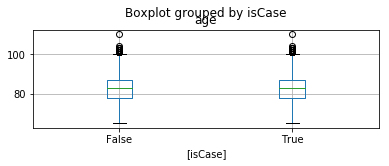

In [13]:
boxplot = df_dist[['isCase', 'age']].boxplot(by='isCase', layout=(2, 1))

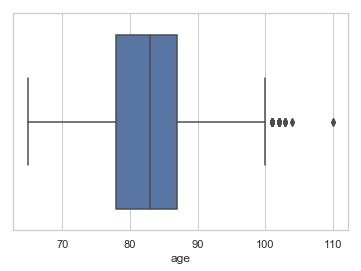

In [14]:
sns.set(style="whitegrid")
age = df_dist
sns.boxplot(x=age['age'])

In [12]:
women = sum(df_dist[df_dist['gender'] == 1]['gender'])

In [13]:
women

33228

In [14]:
men =  sum(df_dist[df_dist['gender'] == 2]['gender'])

In [15]:
men

122204

Importing all of the algorithms used to create the ROC curves

In [16]:
def randomforest(X, y, p = 0.071):
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42, stratify= y)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    result = pd.crosstab(y_test, preds, rownames=['Actual Species'], colnames=['Predicted Species'])
    specificity = result[0][0]/(result[0][0]+result[1][0])
    sensitivity = result[1][1]/(result[1][1] + result[0][1])
    PPV = result[0][0]*p/(result[0][0]*p+result[1][0]*(1-p))
    return sensitivity, specificity, PPV

def randomforestROC(X,y):
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 43, stratify= y)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

def naivebayes(X, y, p = 0.071):
    clf = GaussianNB()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42, stratify= y)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    result = pd.crosstab(y_test, preds, rownames=['Actual Species'], colnames=['Predicted Species'])
    specificity = result[0][0]/(result[0][0]+result[1][0])
    sensitivity = result[1][1]/(result[1][1] + result[0][1])
    PPV = result[0][0]*p/(result[0][0]*p+result[1][0]*(1-p))

    return sensitivity, specificity, PPV

def naivebayesROC(X,y):
    clf = GaussianNB()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42, stratify= y)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

def logisticregression(X, y, p = 0.071):
    clf = LogisticRegression(random_state=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42, stratify= y)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    result = pd.crosstab(y_test, preds, rownames=['Actual Species'], colnames=['Predicted Species'])
    specificity = result[0][0]/(result[0][0]+result[1][0])
    sensitivity = result[1][1]/(result[1][1] + result[0][1])
    PPV = result[0][0]*p/(result[0][0]*p+result[1][0]*(1-p))
 
    return sensitivity, specificity, PPV


def logisticregressionROC(X,y):
    clf = LogisticRegression(random_state=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42, stratify= y)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc



def ROCcomb(X1, y1, clas = 'Time-Independent Data With Count Data'):    
    sns.set()
    sns.set_style("whitegrid")

    lr = LogisticRegression(random_state=1)
    nb = GaussianNB()
    rf = RandomForestClassifier(n_jobs=2, random_state=0)
    
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state= 42, stratify= y1)
    lr.fit(X1_train, y1_train)
    nb.fit(X1_train, y1_train)
    rf.fit(X1_train, y1_train)
    
    probs1 = lr.predict_proba(X1_test)
    preds1 = probs1[:,1]
    fpr1, tpr1, threshold1 = metrics.roc_curve(y1_test, preds1)
    roc_auc1 = metrics.auc(fpr1, tpr1)
    
    probs2 = nb.predict_proba(X1_test)
    preds2 = probs2[:,1]
    fpr2, tpr2, threshold2 = metrics.roc_curve(y1_test, preds2)
    roc_auc2 = metrics.auc(fpr2, tpr2)
    
    probs3 = rf.predict_proba(X1_test)
    preds3 = probs3[:,1]
    fpr3, tpr3, threshold3 = metrics.roc_curve(y1_test, preds3)
    roc_auc3 = metrics.auc(fpr3, tpr3)


    
    plt.title('Receiver Operating Characteristic: %s' % clas)
    plt.plot(fpr1, tpr1, label = 'AUC Logistic Regression = %0.2f' % roc_auc1)
    plt.plot(fpr2, tpr2, label = 'AUC Naive Bayes = %0.2f' % roc_auc2)
    plt.plot(fpr3, tpr3, label = 'AUC Random Forest = %0.2f' % roc_auc3)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return plt.show()


def randomforestFEATURES(df, X, y):
    sns.set()
    sns.set_style("whitegrid")
    features = df.columns[range(len(df.columns))]
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42, stratify= y)
    clf.fit(X_train, y_train)



    clf.score(X_test, y_test)

    feature_importances = pd.DataFrame(clf.feature_importances_,
                                       index = X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)

    feature_importances = feature_importances.reset_index()

    plt.figure(figsize=(15,7))
    sns.barplot(x='index',y='importance',data=feature_importances)
    plt.title('Feature Importances', fontsize = 20)
    plt.xticks(fontsize = 15, rotation=90) # work on current fig
    plt.yticks(fontsize = 15)# work on current fig
    plt.ylabel('Importance', fontsize = 15) # work on current fig
    plt.xlabel('Feature', fontsize = 15) # work on current fig
    return plt.show()





    

In [231]:


nb = GaussianNB()
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state= 42, stratify= y1)
nb.fit(X_train, y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

For the time independant data and the count data

In [28]:
y1 = df['isCase'].values.astype(bool).astype(int)
X1 = df.drop(['patid','isCase', 'index_date', 'yob', 'dementia_codes'], axis=1)

features = X1.columns[range(0,len(X1.columns))]

print(X1.columns)
print(features)

Index(['gender', 'attend_codes__yr_neg5', 'attend_codes__yr_neg4',
       'attend_codes__yr_neg3', 'attend_codes__yr_neg2',
       'attend_codes__yr_neg1', 'attend_codes__yr_0', 'third_party_yr_neg5',
       'third_party_yr_neg4', 'third_party_yr_neg3', 'third_party_yr_neg2',
       'third_party_yr_neg1', 'third_party_yr_0', 'behav_change_yr_neg5',
       'behav_change_yr_neg4', 'behav_change_yr_neg3', 'behav_change_yr_neg2',
       'behav_change_yr_neg1', 'behav_change_yr_0', 'interaction_yr_neg5',
       'interaction_yr_neg4', 'interaction_yr_neg3', 'interaction_yr_neg2',
       'interaction_yr_neg1', 'interaction_yr_0', 'weight_loss_yr_neg5',
       'weight_loss_yr_neg4', 'weight_loss_yr_neg3', 'weight_loss_yr_neg2',
       'weight_loss_yr_neg1', 'weight_loss_yr_0', 'cognitive_decline',
       'cognitive_screening_test', 'dementia_anual_review', 'memory_loss',
       'mmse', 'referal_to_memory', 'referal_to_psych',
       'violent_or_agressive_behaviour', 'behavioural_change',
     

/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: 

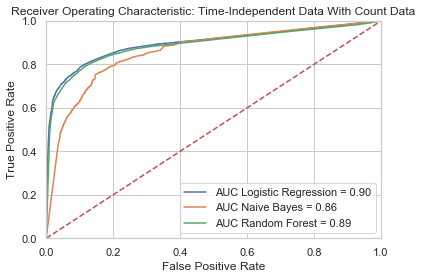

In [29]:
rfsen1, rfspec1, rfppv1 = randomforest(X1, y1)

rfauc1 = randomforestROC(X1, y1)

nbsen1, nbspec1, nbppv1 = naivebayes(X1, y1)

nbauc1 = naivebayesROC(X1, y1)

lrsen1, lrspec1, lrppv1 = logisticregression(X1, y1)

lrauc1 = logisticregressionROC(X1, y1)

ROCcomb(X1, y1)

In [30]:
df1  = pd.DataFrame({'Classifier': ['Random Forest', 'Logistic Regression', 'Naive Bayes'],
                    'AUC': [rfauc1, lrauc1, nbauc1],
                    'Sensitivity' : [rfsen1, lrsen1, nbsen1],
                    'Specificity' : [rfspec1, lrspec1, nbspec1],
                    'PPV' : [rfppv1, lrppv1, nbppv1]})

In [31]:
df1

,Classifier,AUC,Sensitivity,Specificity,PPV
0,Random Forest,0.885066,0.775390,0.900424,0.408666
1,Logistic Regression,0.897035,0.727613,0.944806,0.566771
2,Naive Bayes,0.858322,0.591752,0.921552,0.473075


/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


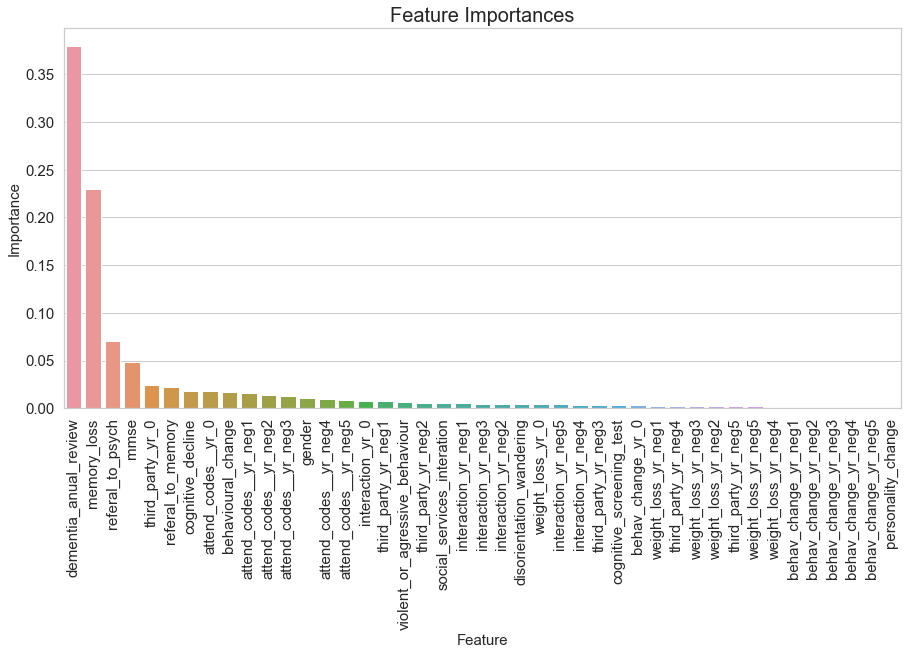

In [32]:
randomforestFEATURES(df,X1,y1)

In [33]:
df.columns

Index(['gender', 'index_date', 'isCase', 'patid', 'yob',
       'attend_codes__yr_neg5', 'attend_codes__yr_neg4',
       'attend_codes__yr_neg3', 'attend_codes__yr_neg2',
       'attend_codes__yr_neg1', 'attend_codes__yr_0', 'third_party_yr_neg5',
       'third_party_yr_neg4', 'third_party_yr_neg3', 'third_party_yr_neg2',
       'third_party_yr_neg1', 'third_party_yr_0', 'behav_change_yr_neg5',
       'behav_change_yr_neg4', 'behav_change_yr_neg3', 'behav_change_yr_neg2',
       'behav_change_yr_neg1', 'behav_change_yr_0', 'interaction_yr_neg5',
       'interaction_yr_neg4', 'interaction_yr_neg3', 'interaction_yr_neg2',
       'interaction_yr_neg1', 'interaction_yr_0', 'weight_loss_yr_neg5',
       'weight_loss_yr_neg4', 'weight_loss_yr_neg3', 'weight_loss_yr_neg2',
       'weight_loss_yr_neg1', 'weight_loss_yr_0', 'dementia_codes',
       'cognitive_decline', 'cognitive_screening_test',
       'dementia_anual_review', 'memory_loss', 'mmse', 'referal_to_memory',
       'referal_to_psyc

Time-independent variables and gradients

In [34]:
df_grad = df.drop(['attend_codes__yr_neg5', 'attend_codes__yr_neg4',
       'attend_codes__yr_neg3', 'attend_codes__yr_neg2',
       'attend_codes__yr_neg1', 'attend_codes__yr_0', 'third_party_yr_neg5',
       'third_party_yr_neg4', 'third_party_yr_neg3', 'third_party_yr_neg2',
       'third_party_yr_neg1', 'third_party_yr_0', 'behav_change_yr_neg5',
       'behav_change_yr_neg4', 'behav_change_yr_neg3', 'behav_change_yr_neg2',
       'behav_change_yr_neg1', 'behav_change_yr_0', 'interaction_yr_neg5',
       'interaction_yr_neg4', 'interaction_yr_neg3', 'interaction_yr_neg2',
       'interaction_yr_neg1', 'interaction_yr_0', 'weight_loss_yr_neg5',
       'weight_loss_yr_neg4', 'weight_loss_yr_neg3', 'weight_loss_yr_neg2',
       'weight_loss_yr_neg1', 'weight_loss_yr_0', 'dementia_codes'], axis=1)
names = ['attend_codes_grad_', 'third_party_grad_', 'behav_change_grad_','interaction_grad_','weight_loss_grad_']
grads = ['54','43','32','21','10']


n = 0 #so that codes doesn't do attend minus third party ect...
z = 0 #so codes have proper names associated
j = 0

for i in range(len(X1.columns)-1):
    print(df.iloc[:,j+5].head(0))
    print(df.iloc[:,j+6].head(0))
    if n == 5:
        print('new')
        z +=1
        n = 0
        j += 1
    else:
        new_column = X1.iloc[:,j+5] - X1.iloc[:,j+6]
        print(names[z] + grads[n])
        df_grad[names[z] + grads[n]] = new_column
        n += 1
        j +=1

Series([], Name: attend_codes__yr_neg5, dtype: float64)
Series([], Name: attend_codes__yr_neg4, dtype: float64)
attend_codes_grad_54
Series([], Name: attend_codes__yr_neg4, dtype: float64)
Series([], Name: attend_codes__yr_neg3, dtype: float64)
attend_codes_grad_43
Series([], Name: attend_codes__yr_neg3, dtype: float64)
Series([], Name: attend_codes__yr_neg2, dtype: float64)
attend_codes_grad_32
Series([], Name: attend_codes__yr_neg2, dtype: float64)
Series([], Name: attend_codes__yr_neg1, dtype: float64)
attend_codes_grad_21
Series([], Name: attend_codes__yr_neg1, dtype: float64)
Series([], Name: attend_codes__yr_0, dtype: float64)
attend_codes_grad_10
Series([], Name: attend_codes__yr_0, dtype: float64)
Series([], Name: third_party_yr_neg5, dtype: float64)
new
Series([], Name: third_party_yr_neg5, dtype: float64)
Series([], Name: third_party_yr_neg4, dtype: float64)
third_party_grad_54
Series([], Name: third_party_yr_neg4, dtype: float64)
Series([], Name: third_party_yr_neg3, dtype: 

IndexError: list index out of range

In [36]:
df_grad.columns

Index(['gender', 'index_date', 'isCase', 'patid', 'yob', 'cognitive_decline',
       'cognitive_screening_test', 'dementia_anual_review', 'memory_loss',
       'mmse', 'referal_to_memory', 'referal_to_psych',
       'violent_or_agressive_behaviour', 'behavioural_change',
       'personality_change', 'disorientation_wandering',
       'social_services_interation', 'attend_codes_grad_54',
       'attend_codes_grad_43', 'attend_codes_grad_32', 'attend_codes_grad_21',
       'attend_codes_grad_10', 'third_party_grad_54', 'third_party_grad_43',
       'third_party_grad_32', 'third_party_grad_21', 'third_party_grad_10',
       'behav_change_grad_54', 'behav_change_grad_43', 'behav_change_grad_32',
       'behav_change_grad_21', 'behav_change_grad_10', 'interaction_grad_54',
       'interaction_grad_43', 'interaction_grad_32', 'interaction_grad_21',
       'interaction_grad_10', 'weight_loss_grad_54', 'weight_loss_grad_43',
       'weight_loss_grad_32', 'weight_loss_grad_21', 'weight_loss_gra

In [39]:
X2 = df_grad.drop(['gender', 'index_date', 'isCase', 'patid', 'yob'], axis=1)
y2 = df_grad['isCase'].values.astype(bool).astype(int)
features2 = X2.columns[range(0,len(X2.columns))]

/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


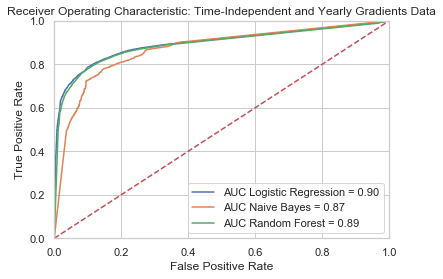

In [40]:
ROCcomb(X2, y2, 'Time-Independent and Yearly Gradients Data')

In [41]:
rfsen2, rfspec2, rfppv2 = randomforest(X2, y1)

rfauc2 = randomforestROC(X2, y1)

nbsen2, nbspec2, nbppv2 = naivebayes(X2, y1)

nbauc2 = naivebayesROC(X2, y1)

lrsen2, lrspec2, lrppv2 = logisticregression(X2, y1)

lrauc2 = logisticregressionROC(X2, y1)

df2  = pd.DataFrame({'Classifier': ['Random Forest', 'Logistic Regression', 'Naive Bayes'],
                    'AUC': [rfauc2, lrauc2, nbauc2],
                    'Sensitivity' : [rfsen2, lrsen2, nbsen2],
                    'Specificity' : [rfspec2, lrspec2, nbspec2],
                    'PPV' : [rfppv2, lrppv2, nbppv2]})

print(df2)

/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


            Classifier       AUC  Sensitivity  Specificity       PPV
0        Random Forest  0.885755     0.773482     0.906290  0.425001
1  Logistic Regression  0.896222     0.727684     0.944735  0.566439
2          Naive Bayes  0.869478     0.641365     0.919538  0.466215


/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


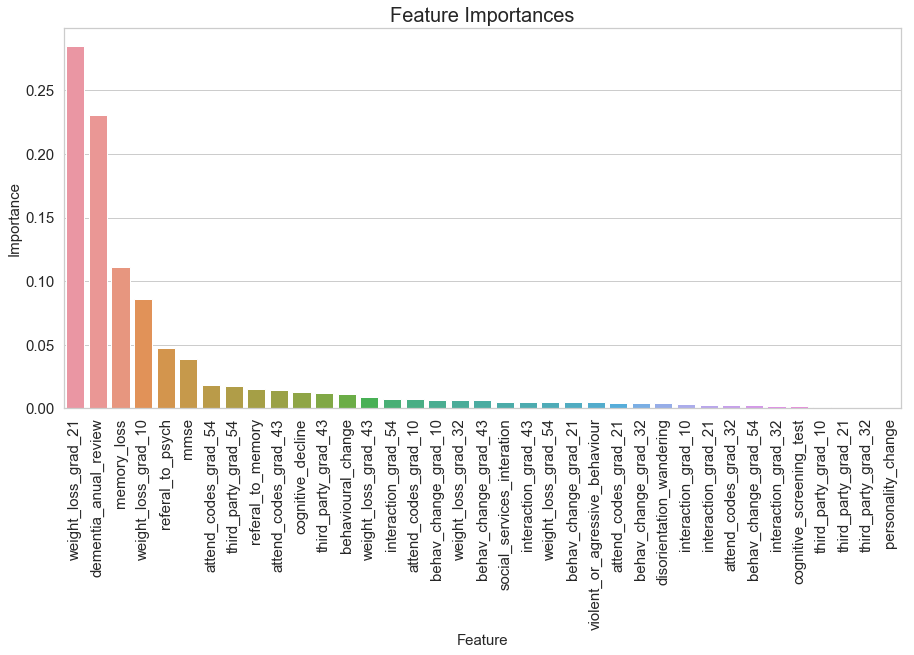

In [42]:
randomforestFEATURES(df_grad,X2,y2)

In [44]:
df_grad_tot = df.drop(['attend_codes__yr_neg5', 'attend_codes__yr_neg4',
       'attend_codes__yr_neg3', 'attend_codes__yr_neg2',
       'attend_codes__yr_neg1', 'attend_codes__yr_0', 'third_party_yr_neg5',
       'third_party_yr_neg4', 'third_party_yr_neg3', 'third_party_yr_neg2',
       'third_party_yr_neg1', 'third_party_yr_0', 'behav_change_yr_neg5',
       'behav_change_yr_neg4', 'behav_change_yr_neg3', 'behav_change_yr_neg2',
       'behav_change_yr_neg1', 'behav_change_yr_0', 'interaction_yr_neg5',
       'interaction_yr_neg4', 'interaction_yr_neg3', 'interaction_yr_neg2',
       'interaction_yr_neg1', 'interaction_yr_0', 'weight_loss_yr_neg5',
       'weight_loss_yr_neg4', 'weight_loss_yr_neg3', 'weight_loss_yr_neg2',
       'weight_loss_yr_neg1', 'weight_loss_yr_0'], axis =1)


print(df_grad_tot.columns)

Index(['gender', 'index_date', 'isCase', 'patid', 'yob', 'dementia_codes',
       'cognitive_decline', 'cognitive_screening_test',
       'dementia_anual_review', 'memory_loss', 'mmse', 'referal_to_memory',
       'referal_to_psych', 'violent_or_agressive_behaviour',
       'behavioural_change', 'personality_change', 'disorientation_wandering',
       'social_services_interation'],
      dtype='object')


In [45]:
names_t = ['attend_codes_grad', 'third_party_grad', 'behav_change_grad','interaction_grad','weight_loss_grad']


n = 0 #so that codes doesn't do attend - tp ect
z = 0 #so codes have proper names asscoiated

for i in range(6):
    print(df.iloc[:,n+5].head(0))
    print(df.iloc[:,n+10].head(0))
    print("next")
    new_column = + X1.iloc[:,n+1] + X1.iloc[:,n+2] +  X1.iloc[:,n+3] + X1.iloc[:,n+4] +X1.iloc[:,n+5] +X1.iloc[:,n+6]
    df_grad_tot[names_t[z]] = new_column/5
    z += 1
    n += 6
    i += 1

        

Series([], Name: attend_codes__yr_neg5, dtype: float64)
Series([], Name: attend_codes__yr_0, dtype: float64)
next
Series([], Name: third_party_yr_neg5, dtype: float64)
Series([], Name: third_party_yr_0, dtype: float64)
next
Series([], Name: behav_change_yr_neg5, dtype: float64)
Series([], Name: behav_change_yr_0, dtype: float64)
next
Series([], Name: interaction_yr_neg5, dtype: float64)
Series([], Name: interaction_yr_0, dtype: float64)
next
Series([], Name: weight_loss_yr_neg5, dtype: float64)
Series([], Name: weight_loss_yr_0, dtype: float64)
next
Series([], Name: dementia_codes, dtype: int64)
Series([], Name: mmse, dtype: int64)
next


IndexError: list index out of range

/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


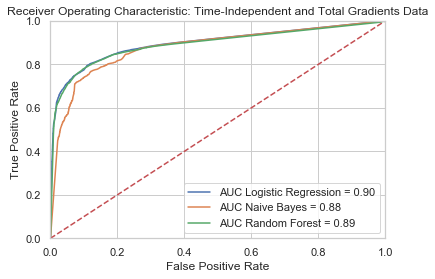

In [52]:
X3 = df_grad_tot.drop(['gender', 'index_date', 'isCase', 'patid', 'yob', 'dementia_codes'], axis=1)
y3 = df_grad_tot['isCase'].values.astype(bool).astype(int)
features3 = X3.columns[range(0,len(X3.columns))]

ROCcomb(X3, y3, 'Time-Independent and Total Gradients Data')

In [53]:
rfsen3, rfspec3, rfppv3 = randomforest(X3, y3)

rfauc3 = randomforestROC(X3, y3)

nbsen3, nbspec3, nbppv3 = naivebayes(X3, y3)

nbauc3 = naivebayesROC(X3, y3)

lrsen3, lrspec3, lrppv3 = logisticregression(X3, y3)

lrauc3 = logisticregressionROC(X3, y3)

df3  = pd.DataFrame({'Classifier': ['Random Forest', 'Logistic Regression', 'Naive Bayes'],
                    'AUC': [rfauc3, lrauc3, nbauc3],
                    'Sensitivity' : [rfsen3, lrsen3, nbsen3],
                    'Specificity' : [rfspec3, lrspec3, nbspec3],
                    'PPV' : [rfppv3, lrppv3, nbppv3]})

print(df3)

/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


            Classifier       AUC  Sensitivity  Specificity       PPV
0        Random Forest  0.888412     0.772351     0.905583  0.422975
1  Logistic Regression  0.896937     0.724221     0.944523  0.565443
2          Naive Bayes  0.878122     0.622495     0.938620  0.538895


Yearly Count, grad plus t inpendent

/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


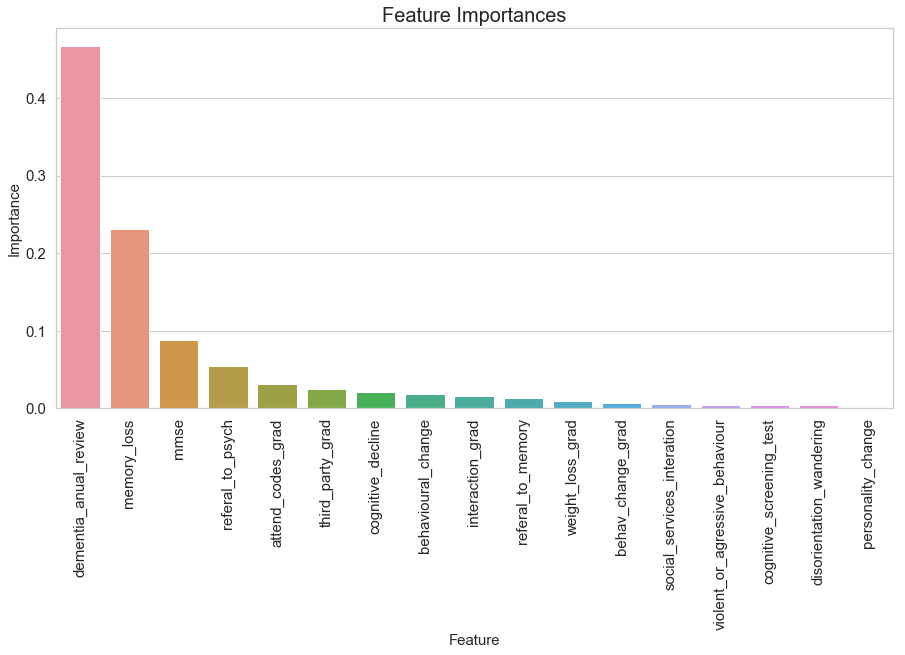

In [57]:
randomforestFEATURES(df_grad_tot, X3 , y3)

In [248]:
df_time.columns

Index(['gender', 'index_date', 'isCase', 'patid', 'yob',
       'attend_codes__yr_neg5', 'attend_codes__yr_neg4',
       'attend_codes__yr_neg3', 'attend_codes__yr_neg2',
       'attend_codes__yr_neg1', 'attend_codes__yr_0', 'third_party_yr_neg5',
       'third_party_yr_neg4', 'third_party_yr_neg3', 'third_party_yr_neg2',
       'third_party_yr_neg1', 'third_party_yr_0', 'behav_change_yr_neg5',
       'behav_change_yr_neg4', 'behav_change_yr_neg3', 'behav_change_yr_neg2',
       'behav_change_yr_neg1', 'behav_change_yr_0', 'interaction_yr_neg5',
       'interaction_yr_neg4', 'interaction_yr_neg3', 'interaction_yr_neg2',
       'interaction_yr_neg1', 'interaction_yr_0', 'weight_loss_yr_neg5',
       'weight_loss_yr_neg4', 'weight_loss_yr_neg3', 'weight_loss_yr_neg2',
       'weight_loss_yr_neg1', 'weight_loss_yr_0'],
      dtype='object')

In [255]:
df_gc = pd.merge(df_time[['patid',
       'attend_codes__yr_neg5', 'attend_codes__yr_neg4',
       'attend_codes__yr_neg3', 'attend_codes__yr_neg2',
       'attend_codes__yr_neg1', 'attend_codes__yr_0', 'third_party_yr_neg5',
       'third_party_yr_neg4', 'third_party_yr_neg3', 'third_party_yr_neg2',
       'third_party_yr_neg1', 'third_party_yr_0', 'behav_change_yr_neg5',
       'behav_change_yr_neg4', 'behav_change_yr_neg3', 'behav_change_yr_neg2',
       'behav_change_yr_neg1', 'behav_change_yr_0', 'interaction_yr_neg5',
       'interaction_yr_neg4', 'interaction_yr_neg3', 'interaction_yr_neg2',
       'interaction_yr_neg1', 'interaction_yr_0', 'weight_loss_yr_neg5',
       'weight_loss_yr_neg4', 'weight_loss_yr_neg3', 'weight_loss_yr_neg2',
       'weight_loss_yr_neg1', 'weight_loss_yr_0']], df_grad, on='patid', how='left').fillna(0)

In [256]:
df_gc.columns

Index(['patid', 'attend_codes__yr_neg5', 'attend_codes__yr_neg4',
       'attend_codes__yr_neg3', 'attend_codes__yr_neg2',
       'attend_codes__yr_neg1', 'attend_codes__yr_0', 'third_party_yr_neg5',
       'third_party_yr_neg4', 'third_party_yr_neg3', 'third_party_yr_neg2',
       'third_party_yr_neg1', 'third_party_yr_0', 'behav_change_yr_neg5',
       'behav_change_yr_neg4', 'behav_change_yr_neg3', 'behav_change_yr_neg2',
       'behav_change_yr_neg1', 'behav_change_yr_0', 'interaction_yr_neg5',
       'interaction_yr_neg4', 'interaction_yr_neg3', 'interaction_yr_neg2',
       'interaction_yr_neg1', 'interaction_yr_0', 'weight_loss_yr_neg5',
       'weight_loss_yr_neg4', 'weight_loss_yr_neg3', 'weight_loss_yr_neg2',
       'weight_loss_yr_neg1', 'weight_loss_yr_0', 'gender', 'index_date',
       'isCase', 'yob', 'cognitive_decline', 'cognitive_screening_test',
       'dementia_anual_review', 'memory_loss', 'mmse', 'referal_to_memory',
       'referal_to_psych', 'violent_or_agressive

/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


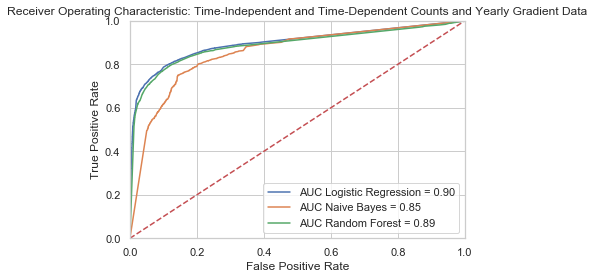

In [260]:
X4 = df_gc.drop(['gender', 'index_date', 'isCase', 'patid', 'yob'], axis=1)
y4 = df_gc['isCase'].values.astype(bool).astype(int)
features4 = X4.columns[range(0,len(X4.columns))]

ROCcomb(X4, y4, 'Time-Independent and Time-Dependent Counts and Yearly Gradient Data')

In [261]:
rfsen4, rfspec4, rfppv4 = randomforest(X4, y4)

rfauc4 = randomforestROC(X4, y4)

nbsen4, nbspec4, nbppv4 = naivebayes(X4, y4)

nbauc4 = naivebayesROC(X4, y4)

lrsen4, lrspec4, lrppv4 = logisticregression(X4, y4)

lrauc4 = logisticregressionROC(X4, y4)

df4  = pd.DataFrame({'Classifier': ['Random Forest', 'Logistic Regression', 'Naive Bayes'],
                    'AUC': [rfauc4, lrauc4, nbauc4],
                    'Sensitivity' : [rfsen4, lrsen4, nbsen4],
                    'Specificity' : [rfspec4, lrspec4, nbspec4],
                    'PPV' : [rfppv4, lrppv4, nbppv4]})

print(df4)

/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


            Classifier       AUC  Sensitivity  Specificity       PPV
0        Random Forest  0.886331     0.773553     0.900283  0.408285
1  Logistic Regression  0.897376     0.727613     0.944594  0.565774
2          Naive Bayes  0.853557     0.593979     0.909997  0.435897


/Users/Joanne/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


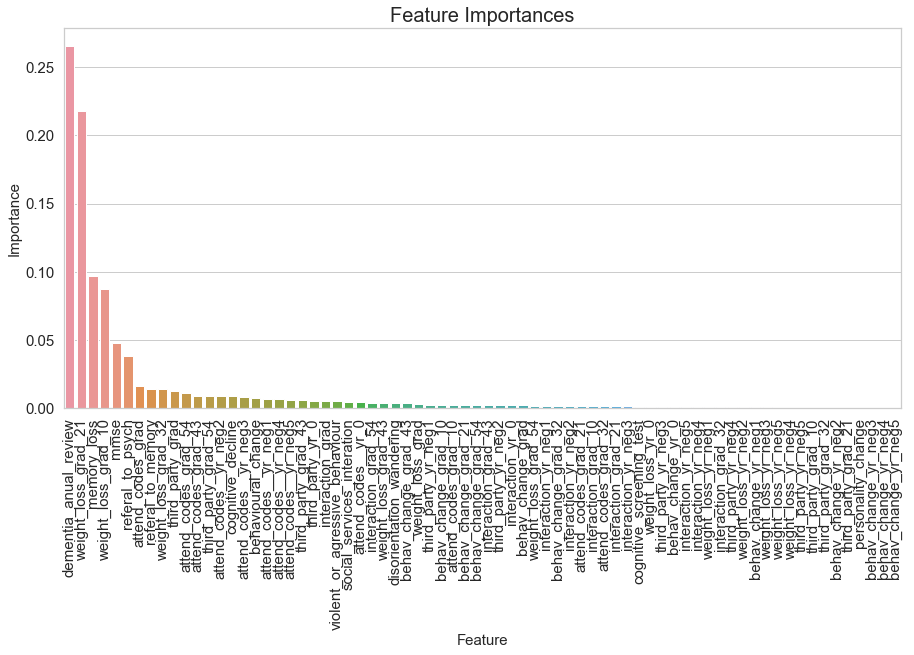

In [263]:
randomforestFEATURES(df_gc,X4,y4)